# B, E, J
author: Louis Richard\
Plots of B, J, E, JxB electric field, and J.E. Calculates J using Curlometer method. 

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from pyrfu import mms, pyrf
from pyrfu.plot import plot_line, use_pyrfu_style

use_pyrfu_style(usetex=True)

Load IGRF coefficients ...


## Define time interval and data path

In [ ]:
mms.db_init(default="local", local="/data/mms")
tint = ["2019-09-14T07:54:00.000", "2019-09-14T08:11:00.000"]

[12-Mar-24 10:55:48] INFO: Updating MMS data access configuration in /usr/local/lib/python3.11/site-packages/pyrfu/mms/config.json...
[12-Mar-24 10:55:48] INFO: Updating MMS SDC credentials in /Users/louisr/.config/python_keyring...


## Load data

### Load background magnetic field (FGM)

In [3]:
b_mms = [mms.get_data("b_dmpa_fgm_srvy_l2", tint, i) for i in range(1, 5)]
b_mms = [pyrf.resample(b_xyz, b_mms[0]) for b_xyz in b_mms]
b_dmpa = pyrf.avg_4sc(b_mms)

[12-Mar-24 10:55:49] INFO: Loading mms1_fgm_b_dmpa_srvy_l2...
[12-Mar-24 10:55:49] INFO: Loading mms2_fgm_b_dmpa_srvy_l2...
[12-Mar-24 10:55:50] INFO: Loading mms3_fgm_b_dmpa_srvy_l2...
[12-Mar-24 10:55:51] INFO: Loading mms4_fgm_b_dmpa_srvy_l2...


### Load electric field (EDP)

In [4]:
e_mms = [mms.get_data("e2d_dsl_edp_fast_l2pre", tint, i) for i in range(1, 5)]
e_mms = [pyrf.resample(e_xyz, e_mms[0]) for e_xyz in e_mms]
e_dsl = pyrf.avg_4sc(e_mms)

[12-Mar-24 10:55:52] INFO: Loading mms1_edp_dce_dsl_fast_l2pre...
[12-Mar-24 10:55:53] INFO: Loading mms2_edp_dce_dsl_fast_l2pre...
[12-Mar-24 10:55:54] INFO: Loading mms3_edp_dce_dsl_fast_l2pre...
[12-Mar-24 10:55:55] INFO: Loading mms4_edp_dce_dsl_fast_l2pre...


### Load ion number density (FPI)

In [5]:
n_i_mms = [mms.get_data("ni_fpi_fast_l2", tint, i) for i in range(1, 5)]
n_i_mms = [pyrf.resample(n_i, n_i_mms[0]) for n_i in n_i_mms]

n_i = pyrf.avg_4sc(n_i_mms)
n_i = pyrf.resample(n_i, b_mms[0])

[12-Mar-24 10:55:56] INFO: Loading mms1_dis_numberdensity_fast...
[12-Mar-24 10:55:56] INFO: Loading mms2_dis_numberdensity_fast...
[12-Mar-24 10:55:56] INFO: Loading mms3_dis_numberdensity_fast...
[12-Mar-24 10:55:56] INFO: Loading mms4_dis_numberdensity_fast...


### Load spacecraft position (MEC)

In [6]:
r_mms = [mms.get_data("r_gse_mec_srvy_l2", tint, i) for i in range(1, 5)]

[12-Mar-24 10:55:56] INFO: Loading mms1_mec_r_gse...
[12-Mar-24 10:55:56] INFO: Loading mms2_mec_r_gse...
[12-Mar-24 10:55:56] INFO: Loading mms3_mec_r_gse...
[12-Mar-24 10:55:57] INFO: Loading mms4_mec_r_gse...


## Compute current density, Hall electric field and E.J

#### Compute current density using curlometer

In [7]:
j_dmpa, div_b, _, jxb_dmpa, _, _ = pyrf.c_4_j(r_mms, b_mms)
j_dmpa.data *= 1e9  # to nA m^{-2}

# Error estimate |\nabla \dot B| / |\nabla \times B|
div_over_curl = div_b.copy()
div_over_curl.data = np.abs(div_over_curl.data) / pyrf.norm(j_dmpa).data

#### Transform current density into field-aligned coordinates

In [8]:
j_fac = pyrf.convert_fac(j_dmpa, b_dmpa, [1, 0, 0])

### Compute Hall electric field

In [9]:
jxb_dmpa.data /= n_i.data[:, None]
jxb_dmpa.data /= 1.6e-19 * 1000  # Convert to (mV/m)
jxb_dmpa.data[np.abs(jxb_dmpa.data) > 100.0] = np.nan  # Remove some questionable fields

### Compute E.J

In [10]:
j_dmpa = pyrf.resample(j_dmpa, e_dsl)
e_dot_j = pyrf.dot(e_dsl, j_dmpa) / 1000  # J (nA/m^2), E (mV/m), E.J (nW/m^3)

## Plot figure

In [11]:
legend_options = dict(ncol=4, loc="upper right", frameon=False, handlelength=1.5)

(18153.329166666666, 18153.34097222222)

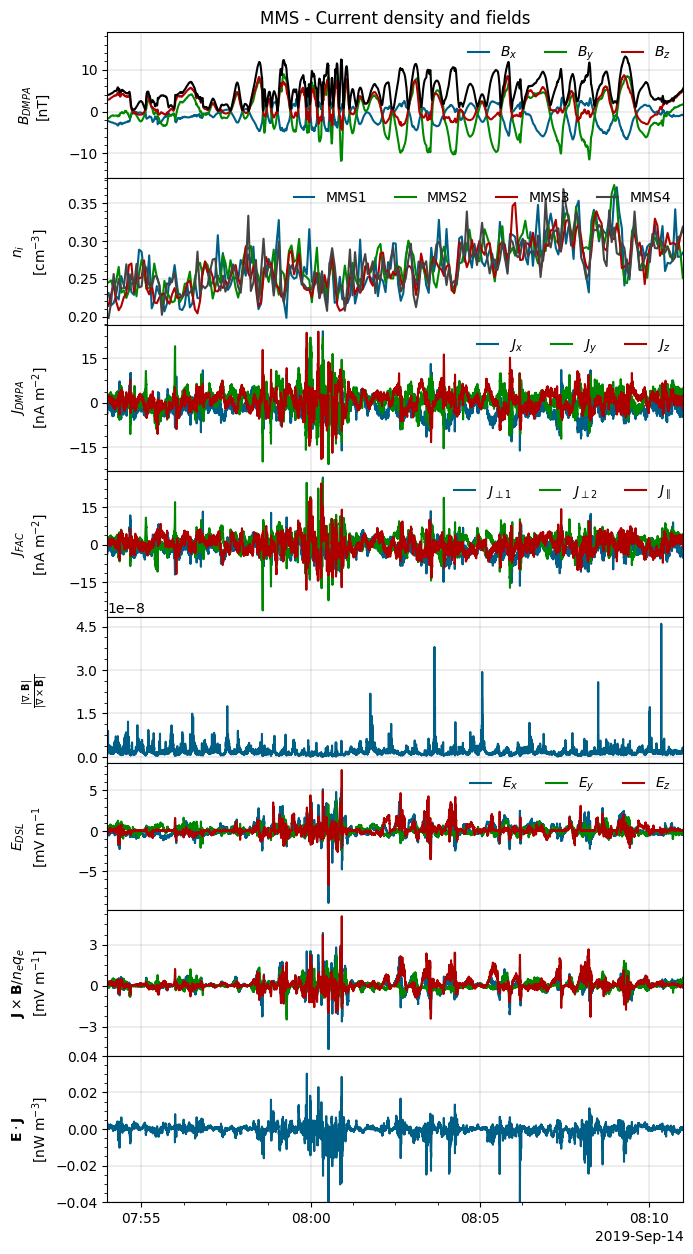

In [12]:
f, axs = plt.subplots(8, sharex="all", figsize=(9, 13))
f.subplots_adjust(hspace=0, left=0.18, right=0.82, bottom=0.05, top=0.95)
plot_line(axs[0], b_dmpa)
plot_line(axs[0], pyrf.norm(b_dmpa), color="k")
axs[0].set_ylim([-16, 19])
axs[0].set_ylabel(r"$B_{DMPA}$" + "\n" + "[nT]")
axs[0].legend([r"$B_{x}$", r"$B_{y}$", r"$B_{z}$"], **legend_options)


labels = []
for i, n in enumerate(n_i_mms):
    plot_line(axs[1], n)
    labels.append("MMS{:d}".format(i + 1))

axs[1].set_ylabel("$n_i$" + "\n" + "[cm$^{-3}$]")
axs[1].legend(labels, **legend_options)

plot_line(axs[2], j_dmpa)
axs[2].set_ylabel(r"$J_{DMPA}$" + "\n" + "[nA m$^{-2}]$")
axs[2].legend(["$J_{x}$", "$J_{y}$", "$J_{z}$"], **legend_options)

plot_line(axs[3], j_fac)
axs[3].set_ylabel("$J_{FAC}$" + "\n" + "[nA m$^{-2}]$")
axs[3].legend([r"$J_{\bot 1}$", r"$J_{\bot 2}$", r"$J_{\parallel}$"], **legend_options)

plot_line(axs[4], div_over_curl)
axs[4].set_ylabel(r"$\frac{|\nabla . \mathbf{B}|}{|\nabla \times \mathbf{B}|}$")

plot_line(axs[5], e_dsl)
axs[5].set_ylabel("$E_{DSL}$" + "\n" + "[mV m$^{-1}$")
axs[5].legend(["$E_{x}$", "$E_{y}$", "$E_{z}$"], **legend_options)

plot_line(axs[6], jxb_dmpa)
axs[6].set_ylabel(
    r"$\mathbf{J} \times \mathbf{B}/n_{e} q_{e}$" + "\n" + "[mV m$^{-1}$]"
)

plot_line(axs[7], e_dot_j)
axs[7].set_ylabel(r"$\mathbf{E} \cdot \mathbf{J}$" + "\n" + "[nW m$^{-3}$]")
axs[7].set_ylim([-0.04, 0.04])
axs[0].set_title("MMS - Current density and fields")

f.align_ylabels(axs)
axs[-1].set_xlim(mdates.datestr2num(tint))